# Word-in-Context Disambiguation (WiC)
This notebook contains the code for the first homework of NLP course 2021 at Sapienza, University of Rome.
<br>
**Author**: Leonardo Emili (1802989)

## Setup the environment

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri May  9 16:23:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
#@title General settings
#@markdown ##### If using GDrive to copy files, make sure to name them correctly.
copy_from_drive = True #@param {type:"boolean"}
try:
    # Setup the project directory if running on Colab
    from google.colab import drive
    !git clone https://github.com/SapienzaNLP/nlp2021-hw1
    %cd nlp2021-hw1

    if copy_from_drive:
        drive.mount('/content/gdrive')
        !cp ../gdrive/MyDrive/GoogleNews-vectors-negative300.txt data/
    else:
        # Download and extract pretrained 300d word2vec word embeddings (may take longer)
        !pip install wget
        !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz -P data/
        !gzip -d data/GoogleNews-vectors-negative300.bin.gz

        # Download and extract pretrained GloVe embeddings
        !wget http://nlp.stanford.edu/data/glove.6B.zip -P data/
        !unzip data/glove.6B.zip -d data/
except:
    pass

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.01 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/nlp2021-hw1/nlp2021-hw1


## Import dependencies

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from collections import namedtuple, defaultdict
from tqdm import tqdm
from typing import *
import numpy as np
import random as rnd
import os
import pickle

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
_ = nltk.download('wordnet')
_ = nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load the dataset

In [17]:
train_df = pd.read_json('data/train.jsonl', lines=True)
train_df.label = train_df.label.apply(lambda v: v == 'True')
train_df.drop("id", axis=1, inplace=True)
dev_df = pd.read_json('data/dev.jsonl', lines=True)
dev_df.label = dev_df.label.apply(lambda v: v == 'True')
dev_df.drop("id", axis=1, inplace=True)

## Data insights

In [18]:
train_df.head()

,lemma,pos,sentence1,sentence2,start1,end1,start2,end2,label
0,play,NOUN,In that context of coordination and integratio...,A musical play on the same subject was also st...,69,73,10,14,False
1,play,NOUN,In that context of coordination and integratio...,"In schools, when water is needed, it is girls ...",69,73,112,116,False
2,esteem,NOUN,We would also like to convey our esteem and co...,"Father Lini said that, because of that, the Un...",33,39,106,112,True
3,esteem,NOUN,We would also like to convey our esteem and co...,This attests to the esteem and trust enjoyed b...,33,39,20,26,True
4,holder,NOUN,This growth is the direct result of the increa...,A person may be either the holder of an option...,74,81,27,33,True


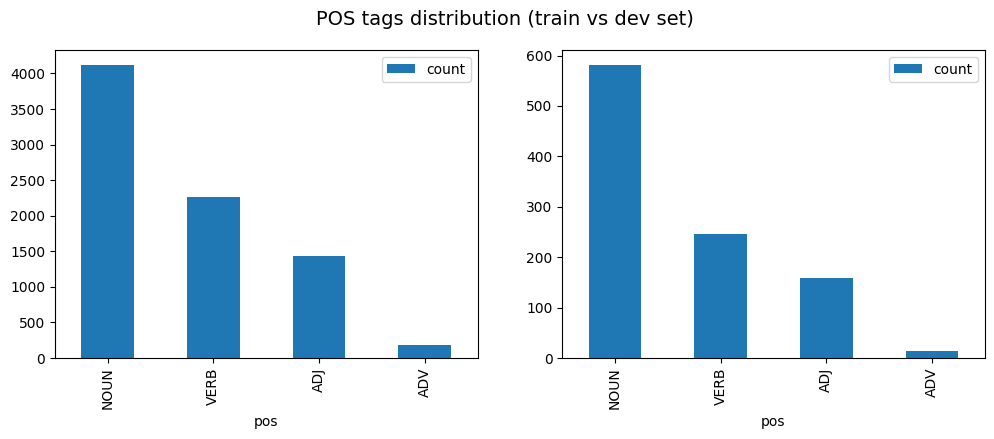

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figsize = (12,4)
fig.suptitle("POS tags distribution (train vs dev set)", fontsize=14)
_ = train_df.pos.value_counts().plot(kind='bar', legend=True, ax=ax1, figsize=figsize)
_ = dev_df.pos.value_counts().plot(kind='bar', legend=True, ax=ax2, figsize=figsize)

## Utility functions

In [20]:
# Useful namedtuple to hold token's information
Token = namedtuple('Token', 'text lemma pos')

def set_seed(seed: int = 42) -> None:
    ''' Manually set the reproducibility seed. '''
    torch.manual_seed(seed)
    np.random.seed(seed)
    rnd.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def parse_sentence(row_sent: pd.Series) -> Tuple[List[Token], List[Token], float]:
    '''
    Returns the sentence pair (s1, s2) that contains a list of parsed tokens.
    '''
    lemma, pos, s1, s2, start1, end1, start2, end2, label = row_sent
    target_word_1, target_word_2 = s1[start1:end1], s2[start2:end2]

    def _parse_sentence(s: str) -> List[Token]:
        ''' Returns the collection of tokens for a given sentence [s]. '''
        lemmatizer = WordNetLemmatizer()
        return [Token(t, lemmatizer.lemmatize(t), None) for t in word_tokenize(s)]

    s1_prefix, s1_suffix = _parse_sentence(s1[:start1]), _parse_sentence(s1[end1:])
    parsed_s1 = s1_prefix \
                + [Token(target_word_1, lemma, pos)] \
                + s1_suffix

    s2_prefix, s2_suffix = _parse_sentence(s2[:start2]), _parse_sentence(s2[end2:])
    parsed_s2 = s2_prefix \
                + [Token(target_word_2, lemma, pos)] \
                + s2_suffix
    return parsed_s1, parsed_s2, float(label)

def parse_sentences(
    df: pd.DataFrame,
    tag: str,
    vectorize_fn = None,
    word2idx: Dict[str, int] = None
    ) -> List[Tuple[List[Token]]]:
    '''
    Returns the collection of sentence pairs, where for each token in the sentence we have
    the named tuple (text, lemma, pos), where pos is None iff that is the target token.
    '''
    parsed_sentences = []
    _word2idx = word2idx.copy() # Override defaultdict default behaviour
    for _, row in tqdm(df.iterrows(), leave=True, position=0, total=len(df), desc=f'Parsing {tag} split'):
        s1, s2, label = parse_sentence(row)
        if vectorize_fn is not None:
            s1, s2 = vectorize_fn(s1, s2, _word2idx)
        parsed_sentences.append((s1, s2, label))
    return parsed_sentences

def vectorize_sentence_pair(
    s1: List[Token],
    s2: List[Token],
    word2idx: Dict[str, int]
    ) -> Tuple[List[Token], List[Token]]:
    ''' Simple vectorizer function that returns a list of indices for each input sentence. '''
    return [word2idx[t.lemma] for t in s1], [word2idx[t.lemma] for t in s2]

def collate_fn(
    batch: List[Tuple[List[Token], List[Token], bool]],
    padding_idx: int = 0
    ) -> Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
    ''' Collate function used to pad input sequences up to maximum local length. '''

    sentence_pair_lengths = [(len(s1),len(s2)) for s1,s2,*_ in batch]
    X1_lengths, X2_lengths = map(torch.tensor, zip(*sentence_pair_lengths))

    X1, X2, Y = zip(*[(torch.tensor(s1),torch.tensor(s2),y) for s1,s2,y in batch])
    X1 = pad_sequence(X1, batch_first=True, padding_value=padding_idx)
    X2 = pad_sequence(X2, batch_first=True, padding_value=padding_idx)

    return (X1, X2), (X1_lengths, X2_lengths), torch.tensor(Y)

def move_to_device(device: str, *args: Tuple[torch.Tensor]) -> Tuple[torch.Tensor]:
    ''' Moves a collections of tensors to the specified device if they are not already there. '''
    return tuple(arg.to(device) if str(arg.device) != device else arg for arg in args)

def plot_logs(logs: Dict[str, List[float]]) -> None:
    ''' Utility function to plot loss/accuracy curves over epochs. '''
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    bins = list(range(len(logs['train_history'])))
    ax1.plot(bins, logs['train_history'], label='Train loss')
    ax1.plot(bins, logs['valid_history'], label='Test loss')
    ax2.plot(bins, logs['train_accuracy'], label='Train accuracy')
    ax2.plot(bins, logs['valid_accuracy'], label='Test accuracy')
    ax1.set_title("Train/dev loss", fontsize=14)
    ax2.set_title("Train/dev accuracy", fontsize=14)
    ax1.set_ylabel('Loss', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper left")
    plt.show()

def save_vocab(vocab: DefaultDict, path: str = 'model/vocab.pkl') -> None:
    ''' Utility function used to persist out the input vocabulary. '''
    with open(path, 'wb') as f:
        pickle.dump(dict(vocab), f)

def make_averager(precision: int = 12) -> Callable[[Optional[float], Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    This utility function is mainly an adaptation from https://github.com/erodola/DLAI-s2-2021
    """
    count = 0
    total = 0
    precision = precision

    def averager(new_value: Optional[float]=None, count_update: Optional[float]=None) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return round(total / count, precision) if count else float("nan")
        count += count_update if count_update is not None else 1
        total += new_value
        return round(total / count, precision)

    return averager

def better_params_found(val_history: List[float], minimize: bool = True) -> bool:
    ''' Returns the decision based on model's accuracy iff minimize is true. '''
    if minimize:
        return True if len(val_history) <= 1 else val_history[-1] < min(val_history[:-1])
    return True if len(val_history) <= 1 else val_history[-1] > max(val_history[:-1])

def get_device(model: nn.Module) -> str:
    ''' Utility function used to determine the device the input model is running on. '''
    return 'cuda:0' if next(model.parameters()).is_cuda else 'cpu'

@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], float],
    loss_avg: Callable[[Optional[float], Optional[float]], float],
    accuracy_avg: Callable[[Optional[float], Optional[float]], float]
    ) -> List[float]:
    ''' Evaluation routine that returns the list of model predictions. '''
    predictions = []
    for (x1, x2), (x1_lengths, x2_lengths), y in dataloader:
        x1, x2, y = move_to_device(get_device(model), x1, x2, y)
        y_hat = model(x1, x2, x1_lengths, x2_lengths)

        # Update dev loss/accuracy
        loss = loss_fn(y_hat, y.float())
        loss_avg(loss.item())
        predictions += y_hat.round().tolist()
        correct_predictions = (y_hat.round() == y).sum().item()
        accuracy_avg(correct_predictions, count_update=y_hat.shape[0])
    return predictions

def load_vocab(path: str = 'model/vocab.pkl', unk_index: int = 1) -> defaultdict:
    ''' Utility function to load a vocabulary from path. '''
    with open(path, 'rb') as f:
         vocab = defaultdict(lambda: unk_index, pickle.load(f))
    return vocab

def vocab_from_df(df: pd.DataFrame, min_frequency: int = 1) -> List[str]:
    '''
    Returns the vocabulary derived the input DataFrame object (e.g. the train split).
    It additionally filters out words that occur less than min_frequency times.
    '''
    counter = Counter()
    lemmatizer = WordNetLemmatizer()
    counter.update([lemmatizer.lemmatize(word) for sentence in df.sentence1 for word in word_tokenize(sentence)])
    counter.update([lemmatizer.lemmatize(word) for sentence in df.sentence2 for word in word_tokenize(sentence)])
    vocab = set([k for k,v in counter.items() if v >= min_frequency])
    return vocab

### Load pretrained word embeddings

In [21]:
def decode_word2vec_binaries(path: str) -> None:
    ''' Utility function used to decode Word2Vec embeddings from .bin file. '''
    if not os.path.exists(f'{path}.txt'):
        from gensim.models.keyedvectors import KeyedVectors
        # Import KeyedVectors to extract the word2vec data structure and save it into .txt file
        word2vec = KeyedVectors.load_word2vec_format(f'{path}.bin', binary=True)
        word2vec.save_word2vec_format(f'{path}.txt', binary=False)
        del word2vec    # Free it from memory and build the vocab by ourselves for the sake of the hw

def load_pretrained_embeddings(
    vocab: Set,
    path: str = 'data/GoogleNews-vectors-negative300',
    words_limit: int = 1_000_000,
    tag: str = 'Word2Vec',
    delim: str = ' ',
    pad_index: int = 0,
    unk_index: int = 1
    ) -> Tuple[Dict[str, int], torch.Tensor]:
    ''' Loads pretrained embeddings from file and maps vocabulary words to vectors. '''

    # Special tokens should have unique indexes
    assert pad_index != unk_index
    if tag == 'Word2Vec':
        # Word2Vec are originally stored as binary file, parse it into plain file to be used later
        decode_word2vec_binaries(path)

    # Define the mapping to vectorize sentences and the embedding tensor
    word2idx = {'<PAD>': pad_index, '<UNK>': unk_index}
    vectors_store = []

    with open(f'{path}.txt', 'r') as f:
        if tag == 'Word2Vec':
            n, embedding_size = map(int, next(f).split())
        elif tag == 'GloVe':
            n, embedding_size = (None, 300)
        else:
            raise Exception('Supported embeddings are Word2Vec and GloVe.')

        # Initialize three vectors: respectively for <PAD> and <UNK> tokens
        vectors_store.append(torch.zeros(embedding_size))
        vectors_store.append(torch.zeros(embedding_size))

        progress = tqdm(f, leave=True, position=0, total=n, desc=f'Loading pretrained {tag} embeddings')
        for i, line in enumerate(progress):
            # Read up to words_limit elements (special tokens excluded)
            if len(word2idx) >= words_limit + 2: break
            word, *embedding = line.split(delim)
            # It is important to only use words that are present in the training set
            if word not in vocab: continue
            embedding = torch.tensor([float(c) for c in embedding])
            word2idx[word] = len(vectors_store)
            vectors_store.append(embedding)

    # word2idx defines the encoding of each word in the vocabulary, otherwise encode it using the <UNK> special token
    word2idx = defaultdict(lambda: unk_index, word2idx)
    vectors_store = torch.stack(vectors_store)
    return word2idx, vectors_store

### Define the training and evaluation routines

In [22]:
def fit_evaluate(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    dev_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], float],
    epochs: int = 50,
    store_best_params_path: int = None,
    display_precision: int = 4,
    early_stopping_patience: int = -1
    ) -> Dict[str, List[float]]:
    '''
    Fits the model on train data and validates it on the development set.
    '''

    # Initialize train/dev history
    train_history = []
    dev_history = []
    train_accuracy = []
    dev_accuracy = []

    # Initialize the patience counter
    patience_counter = 0

    # Store best model's parameters
    best_models_params = {
        'epoch': 0,
        'model_state_dict': {},
        'optimizer_state_dict': {},
        'loss': 0,
    }

    # Set up a simple progress bar and tqdm description
    progress = tqdm(range(epochs), leave=True, position=0)
    description = "Epoch: 0, train_loss: 0, val_loss: 0, train_accuracy: 0, dev_accuracy: 0"
    if early_stopping_patience > 0: description += ", patience_counter: 0"
    progress.set_description(description)

    for epoch in progress:
        # Set the model in training mode
        model.train()

        # Initialize averagers for train set
        train_loss_avg = make_averager(precision=display_precision)
        train_accuracy_avg = make_averager(precision=display_precision)

        for (x1, x2), (x1_lengths, x2_lengths), y in train_dataloader:
            # Zero the gradients to prevent Pytorch from accumulating the gradients
            optimizer.zero_grad()
            x1, x2, y = move_to_device(get_device(model), x1, x2, y)
            y_hat = model(x1, x2, x1_lengths, x2_lengths)

            # Compute the loss and update the averagers
            loss = loss_fn(y_hat, y.float())
            train_loss_avg(loss.item())
            correct_predictions = (y_hat.round() == y).sum().item()
            train_accuracy_avg(correct_predictions, count_update=y_hat.shape[0])

            # Compute the gradient of the loss and update model parameters
            loss.backward()
            optimizer.step()

        # Update train history
        train_history.append(train_loss_avg())
        train_accuracy.append(train_accuracy_avg())

        # Initialize averagers for dev set
        dev_loss_avg = make_averager(precision=display_precision)
        dev_accuracy_avg = make_averager(precision=display_precision)

        # Set the model in evaluation mode
        model.eval()
        evaluate(model, dev_dataloader, loss_fn, dev_loss_avg, dev_accuracy_avg)

        # Update dev history
        dev_history.append(dev_loss_avg())
        dev_accuracy.append(dev_accuracy_avg())

        # Check if we have a better value for the accuracy/loss function
        if better_params_found(dev_accuracy, minimize=False):
            best_models_params = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': dev_loss_avg()
                }
            # Save the current model parameters
            torch.save(best_models_params, store_best_params_path)

        # If early stopping is required and we observe an increase in the dev loss
        if early_stopping_patience > 0 and (epoch > 0 and dev_history[-1] > dev_history[-2]):
            if patience_counter >= early_stopping_patience:
                # Patience treshold reached
                break
            patience_counter += 1


        description = f"Epoch: {epoch+1}, " \
                + f"train_loss: {train_loss_avg()}, " \
                + f"val_loss: {dev_loss_avg()}, " \
                + f"train_accuracy: {train_accuracy_avg()}, " \
                + f"dev_accuracy: {dev_accuracy_avg()}"
        if early_stopping_patience > 0:
            description = description + f", patience_counter: {patience_counter}"
        progress.set_description(description)

    # Initialize averagers for dev set
    test_loss_avg = make_averager(precision=display_precision)
    test_accuracy_avg = make_averager(precision=display_precision)

    # Set the model in evaluation mode and load the best model params
    model.load_state_dict(best_models_params['model_state_dict'])
    model.eval()    # Set the model in eval mode
    evaluate(model, test_dataloader, loss_fn, test_loss_avg, test_accuracy_avg)
    print(f"Test_loss: {test_loss_avg()}, test_accuracy {test_accuracy_avg()}")

    best_model_idx = np.asarray(dev_accuracy).argmax()
    print(f"Best_model_index epoch: {best_model_idx}, valid_history_loss: {dev_history[best_model_idx]}, train_history loss: {train_history[best_model_idx]}, valid_history_accuracy: {max(dev_accuracy)}")

    train_logs = {
        'train_history': train_history,
        'valid_history': dev_history,
        'train_accuracy': train_accuracy,
        'valid_accuracy': dev_accuracy
    }
    return train_logs

## Dataset

In [23]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
class WiCDataset(Dataset):
    ''' A small Dataset class that is responsible for holding data in the form of (sentence1, sentence2, label). '''
    def __init__(self, df: pd.DataFrame, tag: str, vectorize_fn, word2idx: Dict[str, int]) -> None:
        self.sents = parse_sentences(df, tag, vectorize_fn=vectorize_fn, word2idx=word2idx)

    def __len__(self) -> int:
        return len(self.sents)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sents[idx]

# Set reproducibility seed and the device to use
set_seed()
device = 'cuda:0'

# Create vocabulary from train split and load pretrained embeddings
vocabulary = vocab_from_df(train_df, min_frequency=2)
word2idx, vectors_store = load_pretrained_embeddings(vocabulary)

# Since we don't have a test set, randomly sample a small number of elements from the train
# split to be able to understand the actual generalization capabilities of our models.
test_set_size = 64
test_df = pd.concat([
    train_df[train_df.label == True].sample(test_set_size//2),
    train_df[train_df.label == False].sample(test_set_size//2)
])

# Create train/dev/test datasets
train_ds = WiCDataset(train_df.drop(index=test_df.index), 'train', vectorize_sentence_pair, word2idx)
dev_ds = WiCDataset(dev_df, 'dev', vectorize_sentence_pair, word2idx)
test_ds = WiCDataset(test_df, 'test', vectorize_sentence_pair, word2idx)

# Create train/dev/test dataloaders
batch_size = 128
train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
dev_dataloader = DataLoader(dev_ds, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, drop_last=False)

# Save the vocabulary to use it in testing
save_vocab(word2idx)

ModuleNotFoundError: No module named 'gensim'

## Model definition

In [ ]:
class WiCMLP(nn.Module):
    ''' A simple MLP neural network for the WiC task. '''
    def __init__(
        self,
        vectors_store: torch.Tensor,
        hidden_size: int
    ) -> None:
        super().__init__()
        set_seed()  # Set the reproducibility seed
        self.embedding = nn.Embedding.from_pretrained(vectors_store)
        self.embedding_size = vectors_store.size(1)
        self.fc1 = nn.Linear(2 * self.embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(
        self,
        X1: torch.Tensor,
        X2: torch.Tensor,
        X1_lengths: torch.Tensor,
        X2_lengths: torch.Tensor
    ) -> torch.Tensor:
        # Retrieve token word embeddings
        X1 = self.embedding(X1)
        X2 = self.embedding(X2)

        # Aggregate sentence word embeddings ignoring the padding elements
        X1 = torch.stack([x[:length].mean(dim=0) for x,length in zip(X1, X1_lengths)])
        X2 = torch.stack([x[:length].mean(dim=0) for x,length in zip(X2, X2_lengths)])

        # Concatenate the obtained representations
        X = torch.cat((X1, X2), dim=-1)

        # Pass it through two fully connected layers
        X = torch.relu(self.fc1(X))
        X = torch.sigmoid(self.fc2(X).squeeze(1))
        return X

class WiCLSTM(nn.Module):
    ''' A simple BiLSTM neural network for the WiC task. '''
    def __init__(
        self,
        vectors_store: torch.Tensor,
        hidden_size: int,
        batch_size: int,
        bidirectional: bool = True
    ) -> None:
        super().__init__()
        set_seed()  # Set the reproducibility seed
        self.embedding = nn.Embedding.from_pretrained(vectors_store, freeze=True)
        self.embedding_size = vectors_store.size(1)
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.embedding_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.65)
        self.hidden_size = hidden_size
        self.lstm_size = 2 * hidden_size if bidirectional else hidden_size
        self.fc1 = nn.Linear(2 * self.lstm_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(
        self,
        X1: torch.Tensor,
        X2: torch.Tensor,
        X1_lengths: torch.Tensor,
        X2_lengths: torch.Tensor
    ) -> torch.Tensor:
        # Retrieve token word embeddings
        X1 = self.embedding(X1)
        X2 = self.embedding(X2)

        # Apply some dropout
        X1 = self.dropout(X1)
        X2 = self.dropout(X2)

        # Pass the sentences through the LSTM layer
        X1, _ = self.lstm(X1)
        X2, _ = self.lstm(X2)

        # Apply some dropout
        X1 = self.dropout(X1)
        X2 = self.dropout(X2)

        # Aggregate sentence word embeddings ignoring the padding (mean)
        X1 = torch.stack([x[:length].mean(dim=0) for x,length in zip(X1, X1_lengths)])
        X2 = torch.stack([x[:length].mean(dim=0) for x,length in zip(X2, X2_lengths)])

        # Concatenate the obtained representations
        X = torch.cat((X1, X2), dim=-1)

        # Pass it through two fully connected layers
        X = torch.relu(self.dropout(self.fc1(X)))
        X = torch.sigmoid(self.dropout(self.fc2(X)).squeeze(1))

        return X

## Training and hyperparameter tuning

In [ ]:
# Use binary cross entropy as loss function
loss_fn = nn.BCELoss()

# Define the list of hyperparameters
hparams = {
    'mlp': {
        'lr': 0.015,
        'momentum': 0.94,
        'weight_decay': 1e-3
    },
    'mlp_epochs': 400,
    'mlp_hidden_size': 256,

    'lstm': {
        'lr': 0.06,
        'momentum': 0.92,
    },
    'lstm_epochs': 1000,
    'lstm_hidden_size': 256
}

### First approach (simple MLP)

In [ ]:
# Create an istance of the model to use
mlp = WiCMLP(vectors_store, hparams['mlp_hidden_size']).to(device)

# Define the optimizer to use
mlp_optimizer = torch.optim.SGD(
    mlp.parameters(),
    **hparams['mlp']
)

# Fit the model on the train data and evaluate on the dev split
train_logs = fit_evaluate(
    mlp,
    mlp_optimizer,
    train_dataloader,
    dev_dataloader,
    test_dataloader,
    loss_fn,
    hparams['mlp_epochs'],
    store_best_params_path = "model/mlp.pt"
)

# Show how the loss and the accuracy change over time
plot_logs(train_logs)

### Second approach (using LSTM layer)

In [ ]:
# Create an istance of the model to use
lstm = WiCLSTM(vectors_store, hparams['lstm_hidden_size'], batch_size).to(device)

# Define the optimizer to use
lstm_optimizer = torch.optim.SGD(
    lstm.parameters(),
    **hparams['lstm']
)

# Fit the model on the train data and evaluate on the dev split
train_logs = fit_evaluate(
    lstm,
    lstm_optimizer,
    train_dataloader,
    dev_dataloader,
    test_dataloader,
    loss_fn,
    hparams['lstm_epochs'],
    store_best_params_path = "model/lstm.pt"
)

# Show how the loss and the accuracy change over time
plot_logs(train_logs)

## Inference test

In [ ]:
# Load a vocabulary
vocab = load_vocab(path = '<PATH_TO_VOCABULARY>')

# Load model weights for instance for the LSTM model
model_params = torch.load('<PATH_TO_MODEL_WEIGHTS>', map_location=device)
lstm.load_state_dict(model_params['model_state_dict'])
lstm.eval()

# Initialize the averagers and evaluate the model on the dev/test split
dev_loss_avg = make_averager(precision=4)
dev_accuracy_avg = make_averager(precision=4)
evaluate(lstm, dev_dataloader, loss_fn, dev_loss_avg, dev_accuracy_avg)
print(f"Loss: {dev_loss_avg()}, accuracy: {dev_accuracy_avg()}")